# 7.2

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:

conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)


X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 8.373
epoch 4, loss 2.157
epoch 6, loss 0.670
epoch 8, loss 0.239
epoch 10, loss 0.092


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9575, -1.0186]])

# Discussions

커널 사이즈는 합성곱 신경망(CNN)에서 중요한 요소로, 필터가 입력 이미지에서 한 번에 처리하는 영역의 크기를 나타낸다. 작은 커널(예: 3x3)은 이미지의 세밀한 특징을 포착하는 데 효과적이며, 큰 커널(예: 7x7)은 더 넓은 범위의 정보를 추출하는 데 유리하다. 커널 사이즈는 모델의 성능에 영향을 미치며, 큰 커널은 계산 비용이 증가하지만 더 많은 정보를 얻을 수 있다는 장점이 있다.

# 7.3

In [ ]:
import torch
from torch import nn

In [ ]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:

conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# Discussions
이전 레이어와 같은 크기의 출력을 만들기 위해서는 패딩(padding)과 커널 크기(kernel size)가 중요하다. 패딩을 적절히 설정하면 입력과 동일한 크기의 출력을 만들 수 있다. 커널 크기가k*k일 때, 패딩 크기(k-1)/2로 설정해야 한다. 예를 들어, 커널 크기가 3x3이면 패딩을 1로 설정하면 된다.

# 7.4

In [ ]:
import torch
from d2l import torch as d2l

In [ ]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [ ]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 7.5

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# Discussions and Exercises
We could use the softmax operation for pooling. Why might it not be so popular?

소프트맥스 연산을 풀링에 사용하는 것이 인기 없는 이유는 여러 가지가 있다. 첫째, 소프트맥스는 입력 값들의 지수 함수를 계산한 후 이를 정규화하여 가중치를 부여하는 방식으로 작동하기 때문에, 입력 값에 매우 민감하게 반응하여 특정 값에 과도하게 집중하는 경향이 있다. 이로 인해 모델의 일반화 능력이 저하될 수 있다. 둘째, 소프트맥스는 max pooling이나 average pooling에 비해 계산 복잡도가 높다. 마지막으로, 단순한 풀링 방식에 비해 추가적인 연산이 필요하여 학습 속도가 느려진다. 이러한 이유로 소프트맥스 풀링은 실용성이 떨어진다.

# 7.6

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


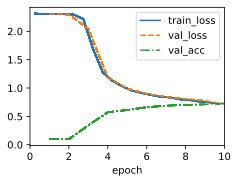

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

# Exercises
학습한 모델의 성능을 확인하기 위해, 5개의 데이터에 대해 예측된 레이블과 실제 레이블을 시각화했다. 이때 모델이 GPU에서 학습되었으므로, 데이터와 모델을 동일한 디바이스 환경(GPU 또는 CPU)으로 설정해주었다

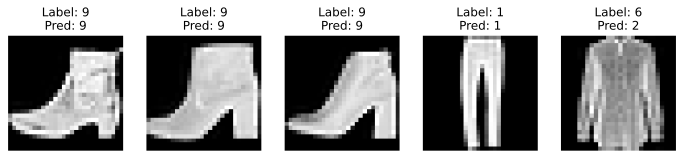

In [ ]:
import torch
import matplotlib.pyplot as plt

train_iter = iter(data.get_dataloader(True))
images, labels = next(train_iter)
images, labels = images[:5], labels[:5]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

model.to(device)

preds = model(images).argmax(axis=1)

fig, axes = plt.subplots(1, 5, figsize=(12, 12))
for i in range(5):
    axes[i].imshow(images[i].cpu().reshape(28, 28).numpy(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}\nPred: {preds[i].item()}")
    axes[i].axis('off')

plt.show()

# 8.2

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


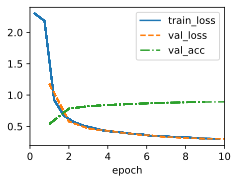

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.6

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


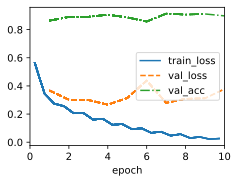

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)